# Vehicle Detection Project
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  


### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Pipeline

In [1]:
# Import library
import os
import glob
import pickle
import numpy as np

import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### 1, Extracted features from the training images.

I decide to convert RGB image to HSV and YUV for HSV nad YUV relevant features are much more distinct from car and non-car images. 
Then I had lots of experiences on different features and their combinations to see their accuracy on predicting vehicles. 
Finally, I choose histogram features of H channel of HSV and HOG features of all HUY channel and combine them as exacted image features.


Color Histogram: 64 bins.
HOG: 12x12 pixels per cell, 2x2 cells per block, 9 orientation

In [2]:
# Define functions to exact image features

# Define function to extract HOG features
def extract_hog(image, pix_per_cell = 12, cell_per_block = 2, orient = 12, vis=False):
    # Container to store features and visualized image
    hog_features = []
    hog_images = []
    for channel in range(image.shape[2]):
        # Exact hog features from every channel
        if vis:
            hog_feature, hog_image = hog(image[:, :, channel], orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=vis, feature_vector=True, transform_sqrt=False)
            # Append the new feature vector to the features list
            hog_features.append(hog_feature)
            hog_images.append(hog_image)
            
        else:
            hog_feature = hog(image[:, :, channel], orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=vis, feature_vector=True, transform_sqrt=False)
            # Append the new feature vector to the features list
            hog_features.append(hog_feature)
            
    # Return hog image and feature vector
    return np.concatenate(hog_features), hog_images


# Define function to return color space histogram features
def color_hist(img, nbins=64, bins_range=(0, 256)):
    # Compute the histogram of the image
    hist_features = np.histogram(img, bins=nbins, range=bins_range)
    # Return feature vector
    return hist_features[0]


# Define a function to take images path list as input, and exact their features
def extract_features(image):
    # Read in image
    if type(image) == str:
        image = mpimg.imread(image)

    # Convert image to HSV and YUV space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    # Exact features
    hog_features = extract_hog(yuv)[0]
    hist_features = color_hist(hsv[:, :, 0])
    
    # Append current image's features
    features = np.concatenate((hog_features, hist_features))
    # Return list of feature vectors
    return features

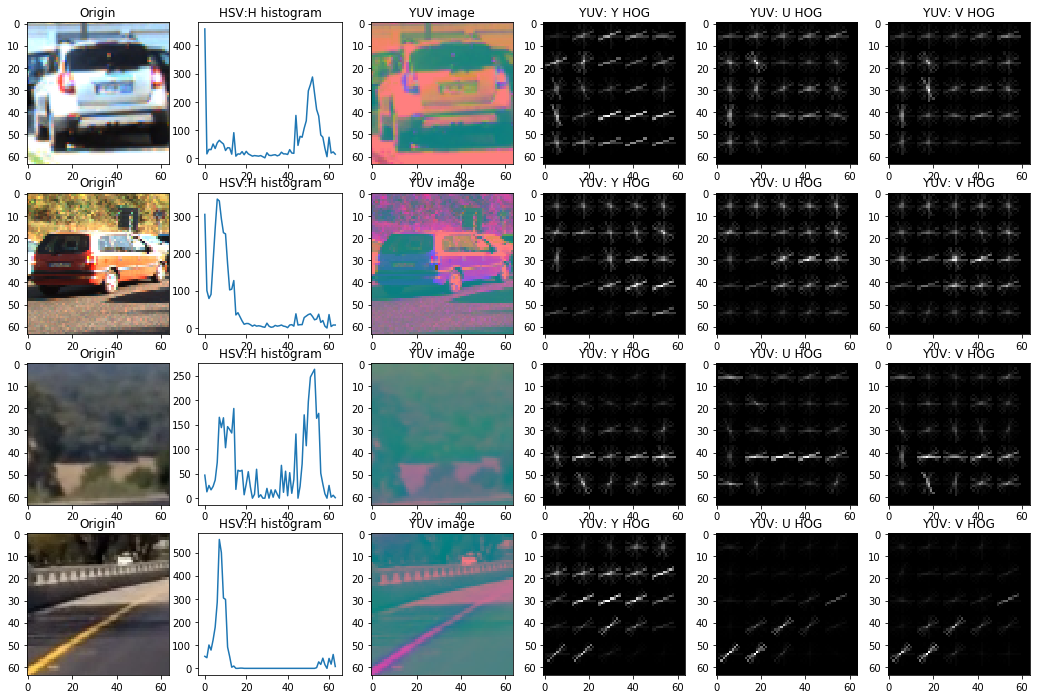

In [3]:
# Different color spaces and HOG features comparison

# Load two samples
vehicle_test1 = mpimg.imread("test_images/vehicle1.png")
vehicle_test2 = mpimg.imread("test_images/vehicle2.png")
non_vehicle_test1 = mpimg.imread("test_images/non-vehicle1.png")
non_vehicle_test2 = mpimg.imread("test_images/non-vehicle2.png")
images = [vehicle_test1, vehicle_test2, non_vehicle_test1, non_vehicle_test2]


fig, axes = plt.subplots(len(images), 6, figsize=(18, 3*len(images)))
for idx, image in enumerate(images):
    # Convert to HSV and YUV space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    # Extract HSV features
    h_features = color_hist(hsv[:, :, 0])
    # Extract YUV HOG features
    yuv_hog_features, yuv_hog_images = extract_hog(yuv, vis=True)
    # Display
    axes[idx, 0].set_title("Origin")
    axes[idx, 0].imshow(image)
    axes[idx, 1].set_title("HSV:H histogram")
    axes[idx, 1].plot(h_features)
    axes[idx, 2].set_title("YUV image")
    axes[idx, 2].imshow(yuv)
    axes[idx, 3].set_title("YUV: Y HOG")
    axes[idx, 3].imshow(yuv_hog_images[0], cmap='gray')
    axes[idx, 4].set_title("YUV: U HOG")
    axes[idx, 4].imshow(yuv_hog_images[1], cmap='gray')
    axes[idx, 5].set_title("YUV: V HOG")
    axes[idx, 5].imshow(yuv_hog_images[2], cmap='gray')

In [4]:
# Exact features of images from data set
import time
def load_data():
    # Images data path
    vehicle_list = glob.glob("vehicles/*.png")
    non_vehicle_list = glob.glob("non-vehicles/*.png")
     
    # Exact images' features
    t = time.time()
    print("vehicle images bumber: ", len(vehicle_list))
    print("non-vehicle images bumber: ", len(non_vehicle_list), "\n")
    car_features = [extract_features(image) for image in vehicle_list]
    non_car_features = [extract_features(image) for image in non_vehicle_list]
    print("It takes {:.2f}s to extract images features\n".format(time.time()-t))
    
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, non_car_features)).astype(np.float64)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=10)


    # Normalization
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)


    # Save extracted features
    with open('feature_label.p', 'wb') as f:
        pickle.dump([X_train, y_train, X_test, y_test, X_scaler], f)

In [5]:
# Load extracted features and labels for training and testing
if not os.path.exists('feature_label.p'):
    load_data()
with open('feature_label.p', 'rb') as f:
    X_train, y_train, X_test, y_test, X_scaler = pickle.load(f)
    
# Print out relevant information
print('Training samples number: ', len(X_train))
print('Testing samples number: ', len(X_test))
print('Feature vector length: ', len(X_train[0]))

Training samples number:  10319
Testing samples number:  2580
Feature vector length:  2368


### 2，Train a classifier using selected features

In [6]:
# Training a Linear SVM
def train_svc():
    t = time.time()
    # Use a linear SVC
    svc = LinearSVC()
    
    t=time.time()
    # Train the SCV
    svc.fit(X_train, y_train)
    print("It takes {:.2f}s to train the SVC.".format(time.time()-t))
    
    # Save trained SVM
    joblib.dump(svc, "train_svc.m")

In [7]:
# Load the trainede SVC
if not os.path.exists("train_svc.m"):
    train_svc()
svc = joblib.load("train_svc.m")

# Test trained SVC
accuracy = svc.score(X_test, y_test)
print('Test accuracy of SVC = ', accuracy)

Test accuracy of SVC =  0.9883720930232558


In the next step, a sliding window techinique will be needed in search of vehicles. For every frame it takes about 200 windows to search the interest region. So an accuracy of 99% + means there will be 2 mistaken judgements, which is quite satisfactory in this case.

### 3，Implement a sliding-window technique in search of vehicles

In [8]:
# Define functions

# Define a function that takes an image, and returns the relevant search windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None]):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # The vehicle appears to be bigger in the bottom of the image
    window_sizes = np.array([64, 80, 96, 128, 160])
    x_overlaps = np.array([0.333, 0.5, 0.5, 0.667, 0.667])
    
    # Compute the spans of x and y direction
    xspan = x_start_stop[1] - x_start_stop[0]  # constant
    yspan = y_start_stop[1] - y_start_stop[0]  # constant
    nx_buffer = (window_sizes * x_overlaps).astype(np.int)  # vector
    # Compute slide step and windows number
    nx_pix_per_steps = (window_sizes*(1 - x_overlaps)).astype(np.int)  # vector
    nx_windows = ((xspan - nx_buffer)/nx_pix_per_steps).astype(np.int)  # vector
    ny_window = len(window_sizes)  # constant
    ny_pix_per_step = np.int(yspan / ny_window + 1)  # constant
    
    # Loop over the interest regions
    for ys in range(ny_window):
        # nx per step, nx window number and window size differ
        window_size = window_sizes[ys]
        nx_pix_per_step = nx_pix_per_steps[ys]
        nx_window = nx_windows[ys]
        for xs in range(nx_window):
            # Calculate window position
            startx =  x_start_stop[1] - xs*nx_pix_per_step
            endx = startx - window_size
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + window_size

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to search the windows in the list
def search_windows(image, windows, clf, scaler):
    # Create an empty list to receive positive detection windows
    on_windows = []
    global k
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[1][0]:window[0][0]], (64, 64))
        # Extract features for that window using single_img_features()
        features = extract_features(test_img)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    # Return windows for positive detections
    return on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=5):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

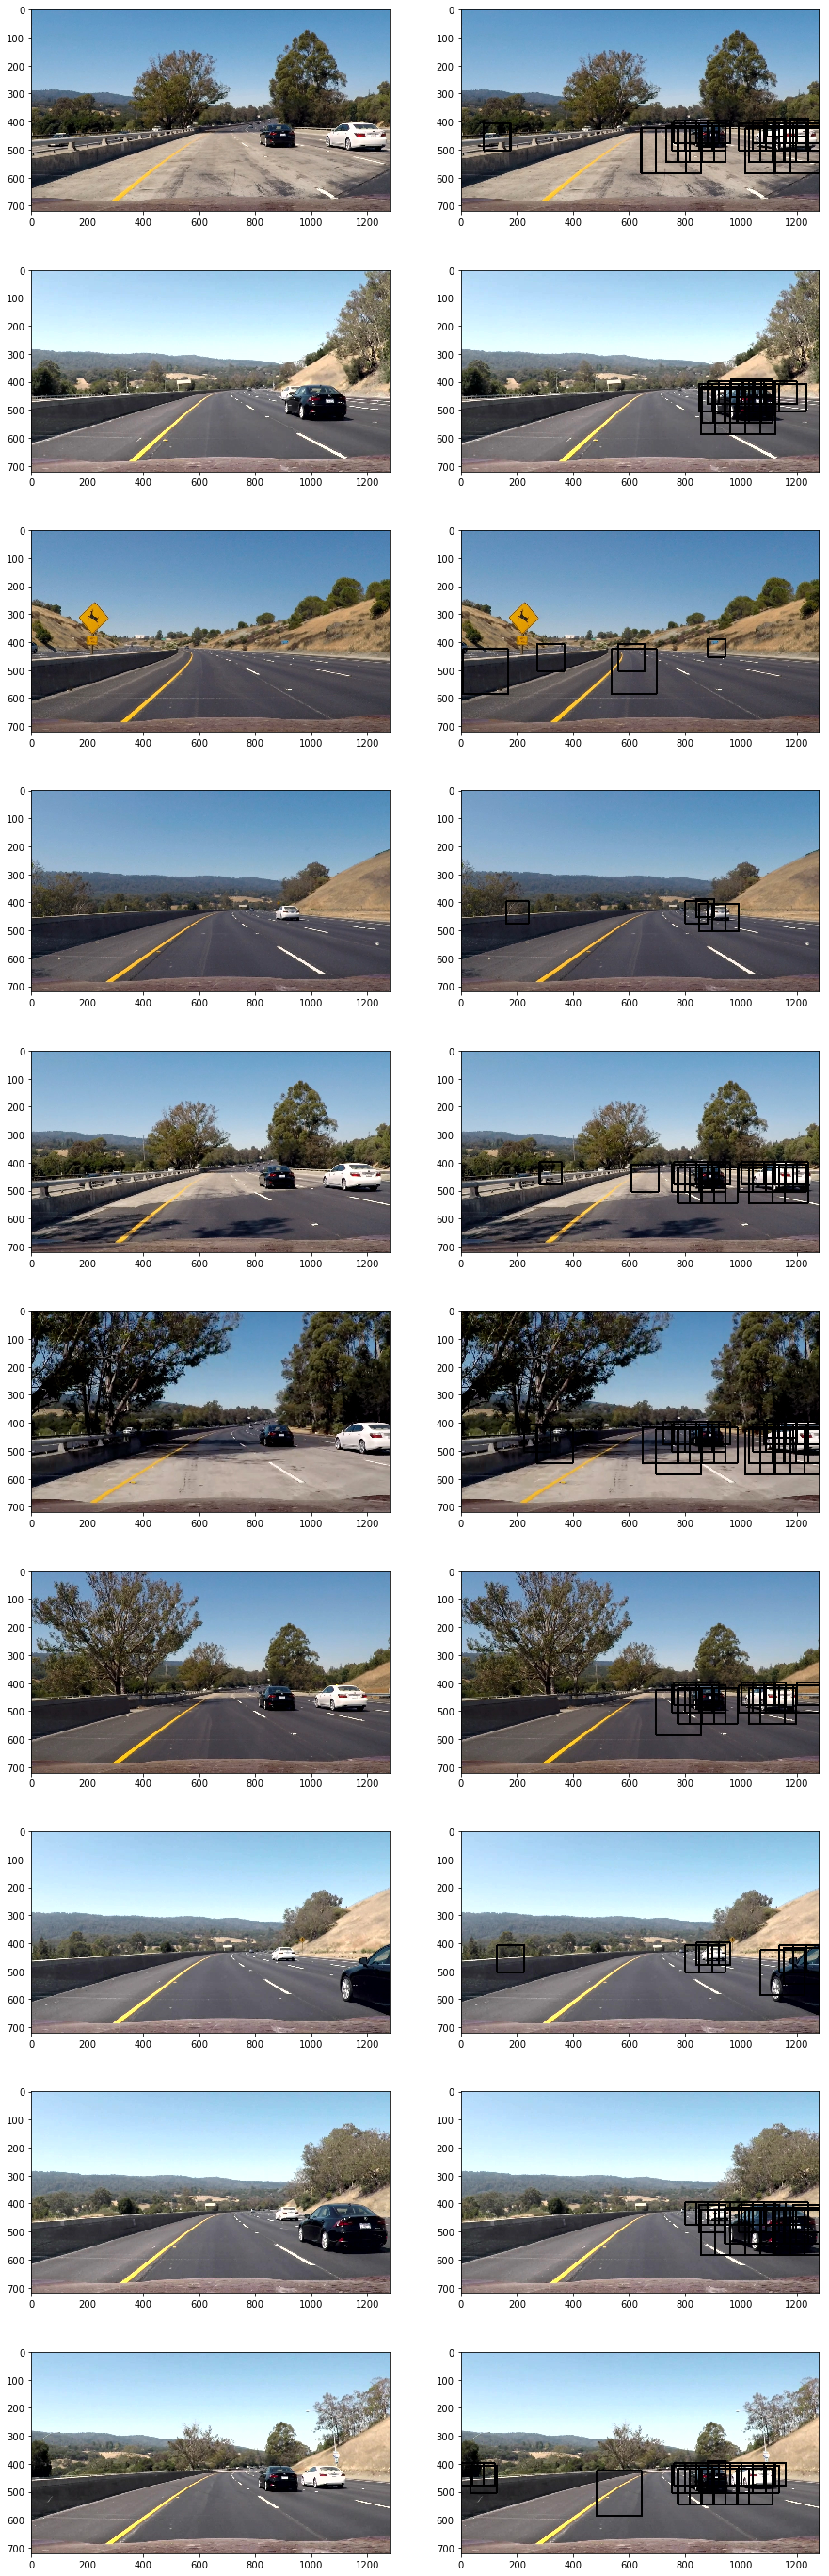

In [9]:
# Apply on test images
test_images = glob.glob("test_images/test*.jpg")

fig, ax = plt.subplots(len(test_images), 2, figsize=(15, 50))
for idx, image_file in enumerate(test_images):
    # Read in image
    image = mpimg.imread(image_file)
    image = image.astype(np.float32)/255
    
    # Apply sliding windows to search vehicles
    window_list = slide_window(image, y_start_stop=[390, 430])
    on_window = search_windows(image, window_list, svc, X_scaler)
    box_image = draw_boxes(image, on_window)
    
    # Display
    ax[idx, 0].imshow(image)
    ax[idx, 1].imshow(box_image)

### 4，Implement a hotmap to locate vehicles

In [10]:
# Define functions

# Define a function to trace the image "heat" situation
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[1][0]:box[0][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


# Apply a threshold to get rid of false positive
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Draw final vehicles location according to labels
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 5)
        
    # Return the image
    return img

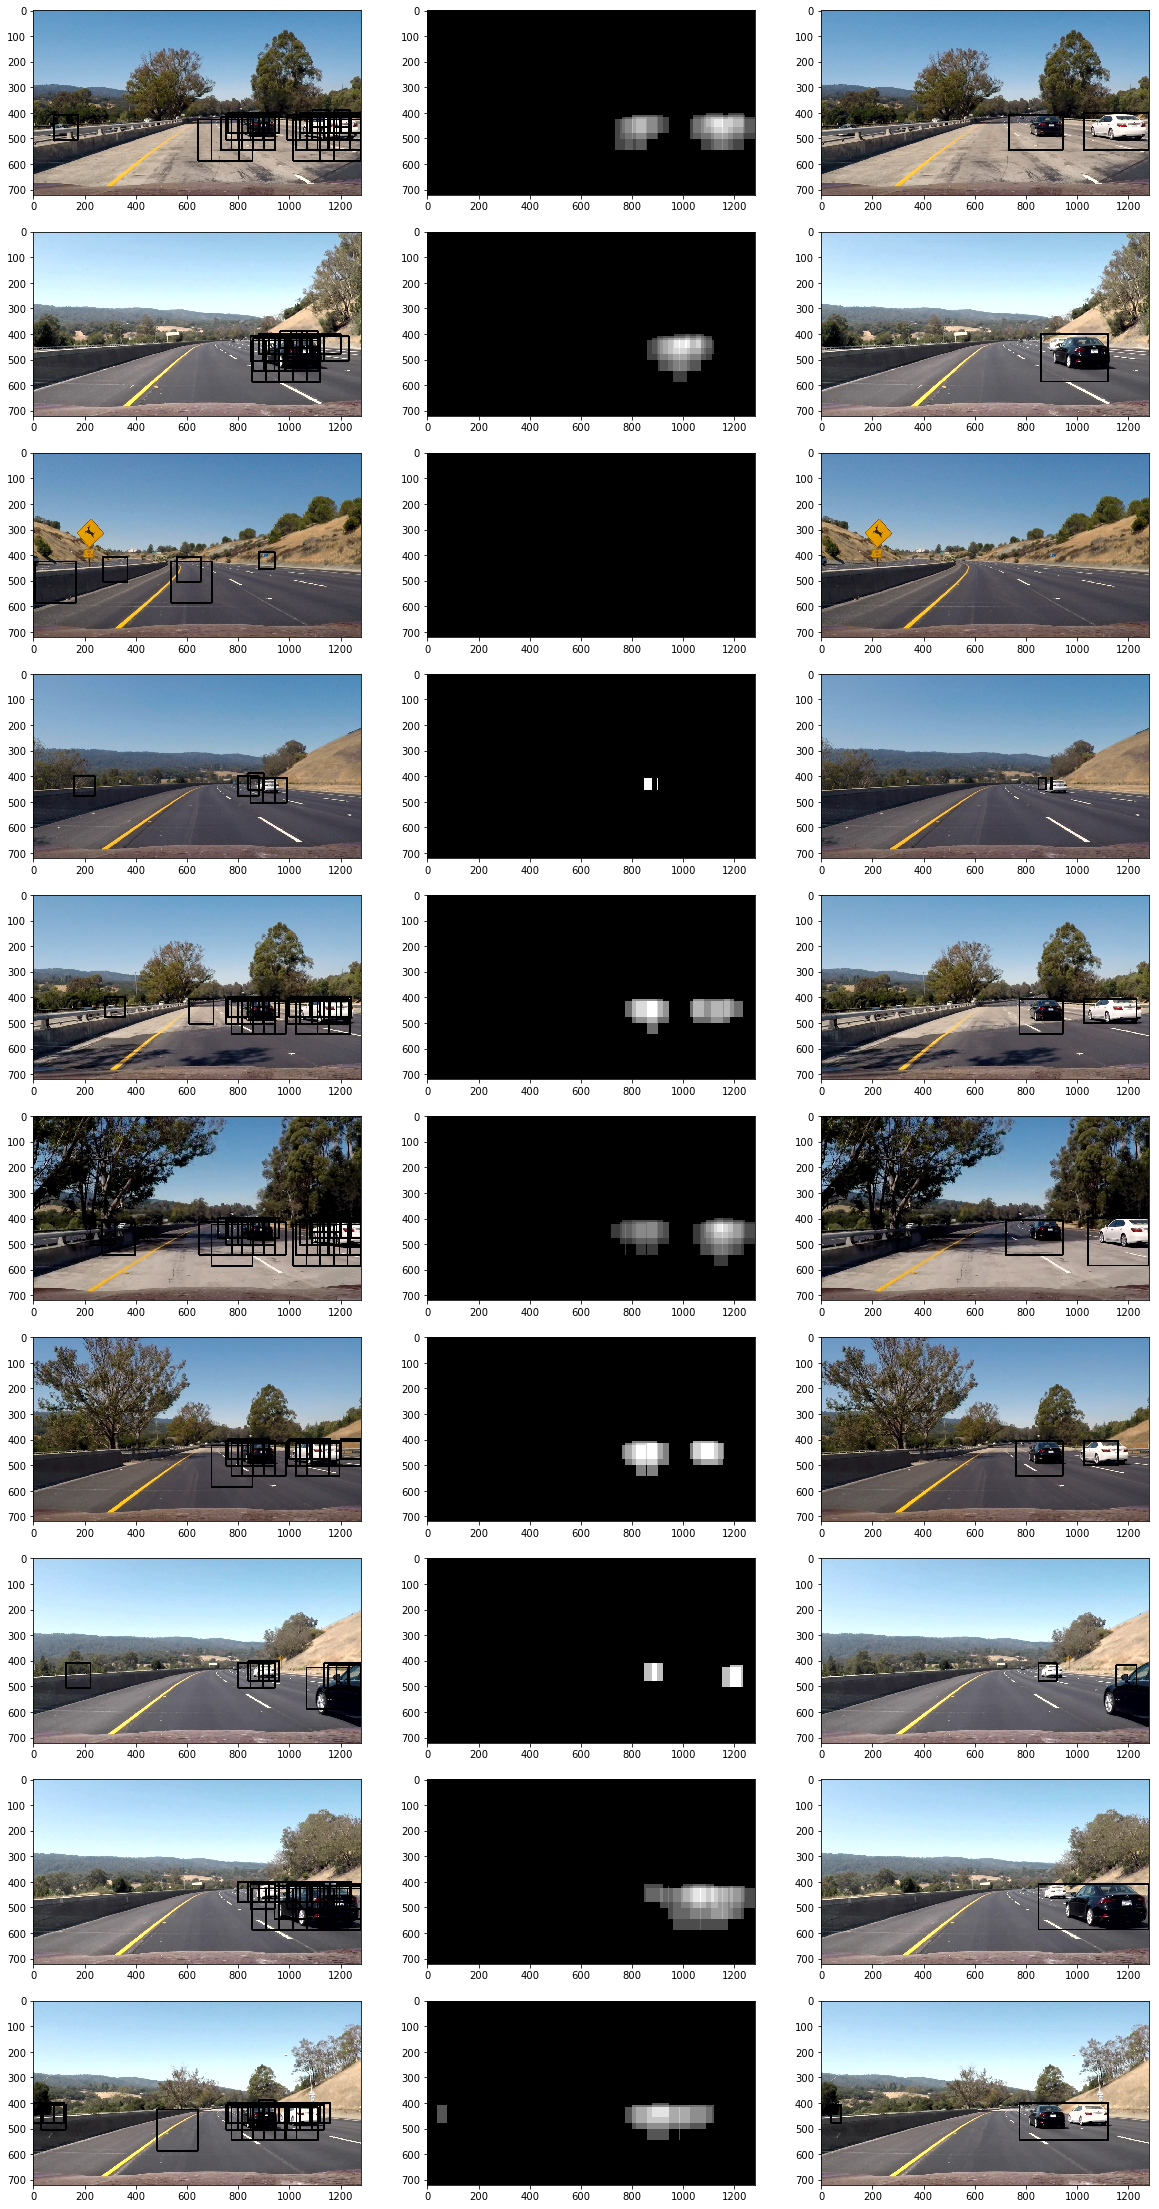

In [11]:
# Apply on test images
test_images = glob.glob("test_images/test*.jpg")

fig, ax = plt.subplots(len(test_images), 3, figsize=(20, 40))
for idx, image_file in enumerate(test_images):
    # Read in image
    image = mpimg.imread(image_file)
    image = image.astype(np.float32)/255
    
    # Apply sliding windows to search vehicles
    window_list = slide_window(image, y_start_stop=[390, 430])
    on_window = search_windows(image, window_list, svc, X_scaler)
    box_image = draw_boxes(image, on_window)
    
    # Apply heatmap to locate vehicle
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    heat = add_heat(heat, on_window)
    heatmap = apply_threshold(heat, 2)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(image), labels)
    
    # Display
    ax[idx, 0].imshow(box_image)
    ax[idx, 1].imshow(heatmap, cmap='gray')
    ax[idx, 2].imshow(result)

## Run the pipeline on project video

When dealing with video, consider using a public heatmap for every 5 frames. It's a good practice to reduce error and remain a stable but still correct detection.

In [12]:
class HeatMap():
    def __init__(self):
        # Reinitialize every COUNTER frame
        self.counter = 0
        # Current collected heatmap
        self.current_heatmap = None
        # Heatmap from last COUNTER frames
        self.last_heatmap = None
        
    def self_update(self, heat):
        # When video starts
        if self.last_heatmap is None:
            # Use the first frame as a start point
            self.current_heatmap = heat
            self.last_heatmap = heat
            
        # Collecting current COUNTER frames
        if self.counter != COUNTER:
            self.counter += 1
            # Add on current heat map
            self.current_heatmap += heat
        # Collect finished
        else:
            # Transfer final heat map
            self.last_heatmap = heatmap.current_heatmap
            # Start a new round
            self.counter = 0
            self.current_heatmap = heat

In [13]:
# Define a pipeline function

def process_image(image):
    # JPG -> PNG
    image = image.astype(np.float32)/255
    
    # Get a list of windows to search for vehicles
    window_list = slide_window(image, y_start_stop=[390, 430])
    # Acquire active windows
    on_window = search_windows(image, window_list, svc, X_scaler)
    
    # Apply heatmap to locate vehicles
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    heat = add_heat(heat, on_window)
    
    # Get rid of false positive
    heatmap.self_update(heat)
    # Use heat map from last COUNTER frames
    heat = apply_threshold(heatmap.last_heatmap, COUNTER*3)
    
    # Label connected active areas
    labels = label(heat)
    # Find final boxes from heatmap using label function
    result = draw_labeled_bboxes((image*255).astype(np.int), labels)
    
    # Return result image
    return result

In [14]:
# Process video
COUNTER = 5
heatmap = HeatMap()
project_output = 'output_video/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
project_clip = clip.fl_image(process_image)
project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:24<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 



In [15]:
HTML("""
<video width="960" height="640" controls>
  <source src="{0}">
</video>
""".format(project_output))